# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

Нужно построить модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import spacy as sp
import re 
import nltk
from nltk.corpus import stopwords

In [2]:
# загружаем список стоп-слов
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Подготовка

### Загрузка данных

In [3]:
# загрузка данных и сохранения их в датафрейм toxic_comments
toxic_comments = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [4]:
# получение первых 10 строк датафрейма toxic_comments
toxic_comments.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [5]:
# вывод основной информации о датафрейме toxic_comments
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [6]:
# определение количества дубликатов
toxic_comments.duplicated().sum()

0

In [7]:
# подсчет количества пропусков в датафрейме toxic_comments
toxic_comments.isna().sum()

text     0
toxic    0
dtype: int64

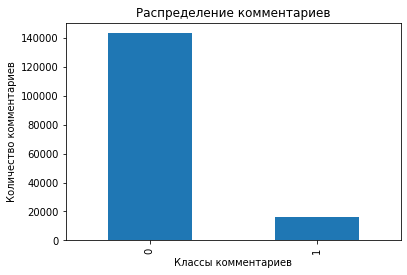

In [8]:
# проверяем распределение классов в датафрейме toxic_comments
toxic_comments['toxic'].value_counts().plot.bar()
plt.title('Распределение комментариев')
plt.ylabel('Количество комментариев')
plt.xlabel('Классы комментариев');

**Вывод:** на первом этапе данные были загружены и сохранены в датафрейм toxic_comments. Была изучена основная информация о датафрейме toxic_comments и осуществлена проверка на наличие дублей и пропусков. В результате которой, в датафрейме toxic_comments пропуски и дубликаты обнаружены не были. Также были изучены распределения комментариев. Из графика видно, что классы распределены неравномерно, токсичных комментарием намного меньше. 

### Лемматизация

In [9]:
# загружаем англоязычные стоп-слова
stop_words = set(stopwords.words('english'))

In [10]:
nlp = sp.load('en_core_web_sm')

In [11]:
# создаем функцию для очистки текста
def clear_text(text):
    c_text = re.sub(r'[^a-zA-z]', ' ', text)
    c_text = c_text.lower()
    c_text = c_text.split()
    cl_text = " ".join(c_text)
    return cl_text

In [12]:
# создаем функцию для лемматизации текста
def lemmatize(text):
    doc = nlp(clear_text(text))
    lemmatized_tokens = [token.lemma_ for token in doc]
    lemmatized_tokens = [ token for token in lemmatized_tokens if token not in stop_words]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

In [13]:
# добавляем столбец text_lem в датафрейм toxic_comments, который содержит очищенный и лемматизированный текст
toxic_comments['text_lem'] = toxic_comments['text'].apply(lemmatize)

In [14]:
# выводим первые 10 строк обновленного датафрейма toxic_comments
toxic_comments.head(10)

,text,toxic,text_lem
0,Explanation\nWhy the edits made under my usern...,0,explanation edit make username hardcore metall...
1,D'aww! He matches this background colour I'm s...,0,aww match background colour I seemingly stuck ...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I really try edit war guy constantly r...
3,"""\nMore\nI can't make any real suggestions on ...",0,I make real suggestion improvement I wonder se...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page
5,"""\n\nCongratulations from me as well, use the ...",0,congratulation I well use tool well talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker piss around work
7,Your vandalism to the Matt Shirvington article...,0,vandalism matt shirvington article revert plea...
8,Sorry if the word 'nonsense' was offensive to ...,0,sorry word nonsense offensive anyway I intend ...
9,alignment on this subject and which are contra...,0,alignment subject contrary dulithgow


**Вывод:** на этапе лемматизации были проведены процедуры по очистке и лемматизации текста из датафрейма toxic_comments. В датафрейм toxic_comments был добавлен новый столбец text_lem с лемматизированным текстом. 

## Обучение

In [15]:
# разделяем датафрейм на признаки (матрица X) и целевую переменную (y)
y = toxic_comments['toxic']
X = toxic_comments.drop('toxic', axis=1)

In [16]:
# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify = y)

In [17]:
# считаем величину TF-IDF для обучающей выборки
count_tf_idf_train = TfidfVectorizer() 
tf_idf_train = count_tf_idf_train.fit_transform(X_train['text_lem'])
display(tf_idf_train.shape)

(143362, 145721)

In [18]:
# считаем величину TF-IDF для тестовой выборки
count_tf_idf_test = TfidfVectorizer() 
tf_idf_test = count_tf_idf_train.transform(X_test['text_lem'])
display(tf_idf_test.shape)

(15930, 145721)

In [19]:
# инициалтзация модели LogisticRegression
model_log = LogisticRegression(random_state=42)

In [20]:
# инициалтзация модели DecisionTreeClassifier
model_tree = DecisionTreeClassifier(random_state=42)

In [21]:
# гиперпараметры модели LogisticRegression
param_grid_log = {"model__C":[0.1, 1.0, 10.0], "model__penalty":["l2"]}

In [32]:
# гиперпараметры модели DecisionTreeClassifier
param_grid_tree = {'model__criterion':['gini','entropy'],'model__max_depth':[2,4,6]}

In [23]:
# перебор гиперпараметров модели LogisticRegression и определение лучших значений
grid_log = GridSearchCV(
    Pipeline([("vect", TfidfVectorizer()),
    ("model", model_log)
]
), 
    param_grid=param_grid_log, 
    cv=5, 
    scoring='f1',
    n_jobs=-1,
    verbose = False
    )
grid_log.fit(X_train['text_lem'], y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1.0, 10.0],
                         'model__penalty': ['l2']},
             scoring='f1', verbose=False)

In [24]:
# вывод лучших показателей для модели LogisticRegression
print('Лучший результат:', grid_log.best_score_)
print('Лучшие параметры:', grid_log.best_params_)

Лучший результат: 0.7797816731393707
Лучшие параметры: {'model__C': 10.0, 'model__penalty': 'l2'}


In [33]:
# перебор гиперпараметров модели DecisionTreeClassifier и определение лучших значений
grid_tree = GridSearchCV(
    Pipeline([("vect", TfidfVectorizer()),
    ("model", model_tree)
]
), 
    param_grid=param_grid_tree, 
    cv=5, 
    scoring='f1',
    n_jobs=-1,
    verbose = False
    )
grid_tree.fit(X_train['text_lem'], y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [2, 4, 6]},
             scoring='f1', verbose=False)

In [34]:
# вывод лучших показателей для модели DecisionTreeClassifier
print('Лучший результат:', grid_tree.best_score_)
print('Лучшие параметры:', grid_tree.best_params_)

Лучший результат: 0.538596242440264
Лучшие параметры: {'model__criterion': 'gini', 'model__max_depth': 6}


In [35]:
# модель с лучшими гиперпараметрами и лучшим значением метрики
best_model = grid_log.best_estimator_

In [37]:
# предсказанные значения для X_test
pred = best_model.predict(X_test['text_lem'])

In [38]:
# проверяем метрику f1_score на тестовой выборке
res_f1 = f1_score(y_test, pred)
res_f1

0.7881944444444445

**Вывод:** на втором этапе данные были разделены на тренировачную и тестовую выборки, каждая выборка была векторизирована и для каждой выборки была посчитана величина TF-IDF. Далее с помощью метода GridSearchCV были выбраны лучшие гиперпараметры для моделей LogisticRegression и DecisionTreeClassifier. Каждая модель была обучена на тренировочной выборке и для каждой модели была посчитана метрика F1. Для модели LogisticRegression с гиперпараметрами {'model__C': 10.0, 'model__penalty': 'l2'} значение метрики F1 на тренировачной выборке было равно 0.78, а для модели DecisionTreeClassifier с гиперпараметрами {'model__criterion': 'gini', 'model__max_depth': 6} значение метрики равно 0.54. Следовательно, для тестовой выборке используем модель LogisticRegression, так как у неё лучший результат. Далее были получены предсказанные значения на тестовой выборке и посчитана метрика F1, равная 0.79.

## Выводы

На первом этапе данные были загружены и сохранены в датафрейм toxic_comments. Была изучена основная информация о датафрейме toxic_comments и осуществлена проверка на наличие дублей и пропусков. Также были изучены распределения комментариев: классы распределены неравномерно, токсичных комментарием намного меньше. Затем данные в столбце text были лемматизированны и очищены от лишних символов. Обновленные данные были добавлены в датафрейм toxic_comments в столбец text_lem.\
На втором этапе данные были разделены на тренировачную и тестовую выборки, каждая выборка была векторизирована и для каждой выборки была посчитана величина TF-IDF. Обучение проходило с помощью моделей LogisticRegression с гиперпараметрами {'C': 10.0, 'penalty': 'l2'} и DecisionTreeClassifier с гиперпараметрами {'model__criterion': 'gini', 'model__max_depth': 6}. Значение метрики F1 на тренировачной выборке для DecisionTreeClassifier было равно 0.54, а для LogisticRegression - 0.78. Следовательно, для тестовой выборки используем модель LogisticRegression. Далее были получены предсказанные значения на тестовой выборке и посчитана метрика F1, равная 0.79.